# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.17 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


In [6]:
dones

[True, True]

When finished, you can close the environment.

In [7]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import random
from collections import namedtuple, deque
from matplotlib import pyplot as plt

In [9]:
def hidden_init(layer):
    '''Function for initializing the neural network weights'''
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    '''Neural network for the Actor'''
    def __init__(self, state_size, action_size, hidden_size = 128, hidden_size1 = 64):
        super(Actor,self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size1)
        self.fc3 = nn.Linear(hidden_size1,action_size)
        self.reset_parameters()
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))

class Critic(nn.Module):
    '''Neural network for the Critic'''
    def __init__(self, state_size, action_size, hidden_size_s = 128, hidden_size = 64):
        super(Critic, self).__init__()
        self.fs = nn.Linear(2*state_size,hidden_size_s)
        self.fc1 = nn.Linear(hidden_size_s+2*action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.reset_parameters()
    def reset_parameters(self):
        self.fs.weight.data.uniform_(*hidden_init(self.fs))
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)   
    def forward(self, state_full, action_full):
        state_full = torch.cat((torch.squeeze(state_full[:,0,:]),torch.squeeze(state_full[:,1,:])),dim=-1)
        action_full = torch.cat((torch.squeeze(action_full[:,0,:]),torch.squeeze(action_full[:,1,:])),dim=-1)
        xs = F.leaky_relu(self.fs(state_full))
        x = torch.cat((xs, action_full), dim = 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
class OUNoise:
    '''Noise based on Ornstein-Uhlenbeck process'''
    def __init__(self, size, mu=0., theta=0.2, sigma=0.15):
        self.mu = mu*np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()
    def reset(self):
        self.state = copy.copy(self.mu)
    def sample(self):
        x = self.state
        dx = self.theta*(self.mu - x) + self.sigma*np.array([random.random() for i in range(len(x))])
        self.state = x+dx
        return self.state

class ReplayBuffer:
    '''Replay buffer to store all experiences tuples'''
    def __init__(self, buffer_size, batch_size):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.memory = deque(maxlen = buffer_size)
        self.experience = namedtuple('Experience',field_names=['state', 'action', 'reward', 'next_state', 'done'])
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    def sample(self):
        experience = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.stack([e.state for e in experience if e is not None],axis=0)).float().to(device)
        actions = torch.from_numpy(np.stack([e.action for e in experience if e is not None],axis=0)).float().to(device)
        rewards = torch.from_numpy(np.stack([e.reward for e in experience if e is not None],axis=0)).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experience if e is not None],axis=0)).float().to(device)
        dones = torch.from_numpy(np.stack([e.done for e in experience if e is not None],axis=0).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)
    def __len__(self):
        return len(self.memory)

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class ddpg:
    '''Class of a single agent based on deep deterministic policy gradien network'''
    def __init__(self, state_size, action_size):
        self.state_size= state_size
        self.action_size = action_size
        self.actor = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_target.eval()
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optim = optim.Adam(self.actor.parameters(), lr = 1e-4)
        self.critic = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_target.eval()
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optim = optim.Adam(self.critic.parameters(), lr = 3e-4)
        self.noise = OUNoise(action_size)
        self.noise_reduction = 0.99
        self.noise_coefficient = 1
        
    def act(self, state, add_noise=True):
        x = torch.from_numpy(state).float().to(device)
        self.actor.eval()
        with torch.no_grad():
            action = self.actor(x).cpu().data.numpy()
        if add_noise:
            action+=self.noise_coefficient*self.noise.sample()
            #self.noise_coefficient*=self.noise_reduction
        return np.clip(action,-1,1)
    
    def soft_update(self, tau = 0.001):
        for local_param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            with torch.no_grad():
                target_param.data.copy_(tau*local_param+(1-tau)*target_param)
            
        for local_param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            with torch.no_grad():
                target_param.data.copy_(tau*local_param+(1-tau)*target_param)
            
    def reset(self):
        self.noise.reset()
        

In [11]:
class maddpg:
    '''Define multiple agent, experience replay buffer, and training for the ciritc and actor network for each agent'''
    def __init__(self, GAMMA=0.99):
        self.GAMMA= GAMMA
        self.ddpg_agents = [ddpg(state_size,action_size), ddpg(state_size,action_size)]
        self.replay_buffer = ReplayBuffer(buffer_size, batch_size)
    def act(self, obs_all_agents):
        actions = [agent.act(obs) for agent, obs in zip(self.ddpg_agents, obs_all_agents)]
        return actions
    def learn(self):
        if len(self.replay_buffer)>batch_size:
            experience = self.replay_buffer.sample()
            '''learning for critics'''
            full_states, full_actions, full_rewards, full_next_states, full_dones = experience
            with torch.no_grad():    
                full_next_actions = torch.stack([self.ddpg_agents[i].actor_target(torch.squeeze(full_next_states[:,i,:])) for i in range(2)],dim=1)
            for i, agent in enumerate(self.ddpg_agents):
                Q_next = agent.critic_target(full_next_states,full_next_actions)
                Q_target = full_rewards[:,i]+self.GAMMA*torch.squeeze(Q_next)*(1-full_dones[:,i])
                Q_expected = agent.critic(full_states,full_actions)
                huber_loss = torch.nn.SmoothL1Loss()
                critic_loss = huber_loss(torch.squeeze(Q_expected), Q_target.detach())
                agent.critic_optim.zero_grad()
                critic_loss.backward()
                agent.critic_optim.step()
            '''learning for actors'''
            for i, agent in enumerate(self.ddpg_agents):
                full_pred_actions = []
                for j in range(2):
                    if j==i:
                        full_pred_actions.append(agent.actor(torch.squeeze(full_states[:,j,:])))
                    else:
                        full_pred_actions.append(self.ddpg_agents[j].actor(torch.squeeze(full_states[:,j,:])).detach())                        
                full_pred_actions = torch.stack(full_pred_actions,dim=1)
                agent.critic.eval()
                pred_Q = agent.critic(full_states,full_pred_actions)
                actor_loss= -pred_Q.mean()
                agent.actor_optim.zero_grad()
                actor_loss.backward()
                agent.actor_optim.step()
            for agent in self.ddpg_agents:
                agent.soft_update()
    def add(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
    def reset(self):
        for agent in self.ddpg_agents:
            agent.reset()

In [12]:
buffer_size = 1000000
batch_size = 128
magent = maddpg()
scores_record = []
scores_record_100 = []
scores_deque = deque(maxlen=100)
solved = False

Environment solved in 3862 episodes
Episode:3870 Average score (100 episodes): 0.5315000079385936
Episode:3880 Average score (100 episodes): 0.5705000085197389
Episode:3890 Average score (100 episodes): 0.5886000087857246
Episode:3900 Average score (100 episodes): 0.6215000092796982
Episode:3910 Average score (100 episodes): 0.6046000090241432
Episode:3920 Average score (100 episodes): 0.5777000086195767
Episode:3930 Average score (100 episodes): 0.5778000086173415
Episode:3940 Average score (100 episodes): 0.5657000084407627
Episode:3950 Average score (100 episodes): 0.5646000084280968
Episode:3960 Average score (100 episodes): 0.49960000745952127
Episode:3970 Average score (100 episodes): 0.4806000071763992
Episode:3980 Average score (100 episodes): 0.5066000075638294
Episode:3990 Average score (100 episodes): 0.5386000080406665
Episode:4000 Average score (100 episodes): 0.523700007814914


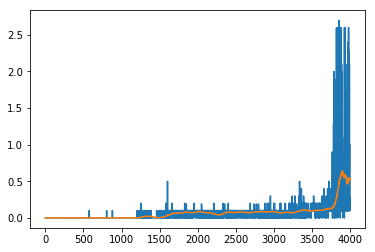

In [18]:
def train(epochs = 1000):
    '''Agent interact with the environment and its experience is stored and sampled to train the actor and critic neural network'''
    global solved
    for i_episode in range(3861,4000):
        env_info = env.reset(train_mode=True)[brain_name]
        magent.reset()
        states = env_info.vector_observations
        scores = np.zeros(2)
        while True:
            actions = magent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            scores+=rewards
            magent.add(states,actions,rewards,next_states, dones)
            magent.learn()
            magent.learn()
            states = next_states
            if np.any(dones):
                break
        max_score = np.max(scores)
        scores_record.append(max_score)
        scores_deque.append(max_score)
        scores_record_100.append(np.mean(scores_deque))
        if (i_episode+1)%10==0:
            print('Episode:{} Average score (100 episodes): {}'.format(i_episode+1,np.mean(scores_deque)))
        if (np.mean(scores_deque)>0.5) and (solved == False):
            print('Environment solved in {} episodes'.format(i_episode+1))
            solved = True
        
train()
plt.plot(scores_record)
plt.plot(scores_record_100)

In [21]:
'''save checkpoints'''
torch.save(magent.ddpg_agents[0].actor.state_dict(), 'checkpoint_actor_1.pth')
torch.save(magent.ddpg_agents[0].critic.state_dict(), 'checkpoint_critic_1.pth')

torch.save(magent.ddpg_agents[0].actor.to('cpu').state_dict(), 'checkpoint_actor_cpu_1.pth')
torch.save(magent.ddpg_agents[0].critic.to('cpu').state_dict(), 'checkpoint_critic_cpu_1.pth')

torch.save(magent.ddpg_agents[1].actor.state_dict(), 'checkpoint_actor_2.pth')
torch.save(magent.ddpg_agents[1].critic.state_dict(), 'checkpoint_critic_2.pth')

torch.save(magent.ddpg_agents[1].actor.to('cpu').state_dict(), 'checkpoint_actor_cpu_2.pth')
torch.save(magent.ddpg_agents[1].critic.to('cpu').state_dict(), 'checkpoint_critic_cpu_2.pth')

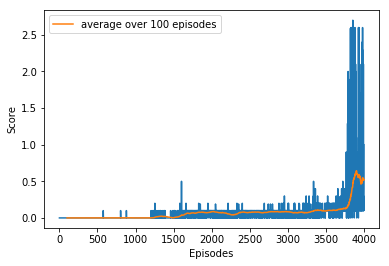

In [22]:
'''plot score'''
fig, ax = plt.subplots()
score_record_mean = [np.mean(s) for s in scores_record]
ax.plot(score_record_mean)
ax.plot(np.arange(100,len(scores_record_100)),scores_record_100[100:], label = 'average over 100 episodes')
ax.set_xlabel('Episodes')
ax.set_ylabel('Score')
fig.patch.set_facecolor('white')
plt.legend() 
plt.rcParams.update({'font.size': 12})